In [33]:
import os, getpass
from dotenv import load_dotenv
load_dotenv()

True

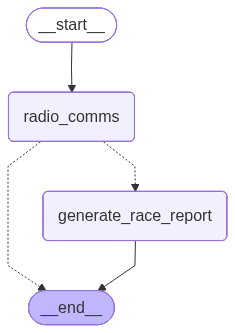

In [34]:
from typing import Literal
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage, AIMessage
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableConfig
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

class RaceSessionState(MessagesState):
    race_summary: str

def call_race_control(state: RaceSessionState, config: RunnableConfig):
    summary = state.get("race_summary", "")
    if summary:
        system_message = f"Summary of the race session so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = model.invoke(messages, config)
    return {"messages": response}

def generate_race_report(state: RaceSessionState):
    summary = state.get("race_summary", "")
    if summary:
        summary_message = (
            f"This is the race report so far: {summary}\n\n"
            "Update the report based on the new radio messages above:"
        )
    else:
        summary_message = "Generate a brief race report based on the radio messages above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"race_summary": response.content, "messages": delete_messages}

def should_generate_report(state: RaceSessionState) -> Literal["generate_race_report", END]:
    messages = state["messages"]
    if len(messages) > 6:
        return "generate_race_report"
    return END

workflow = StateGraph(RaceSessionState)
workflow.add_node("radio_comms", call_race_control)
workflow.add_node(generate_race_report)

workflow.add_edge(START, "radio_comms")
workflow.add_conditional_edges("radio_comms", should_generate_report)
workflow.add_edge("generate_race_report", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
config = {"configurable": {"thread_id": "f1_stream_updates"}}

input_message = HumanMessage(content="Box this lap.", name="RaceEngineer")
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print(chunk)

{'radio_comms': {'messages': AIMessage(content='Copy that. Box this lap and prepare for a pit stop.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 14, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CTgvvsgaT7tfh7Nhk0iIqJj3DwgWH', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--77c9c2bf-e2d5-431a-b248-87c1a7348c83-0', usage_metadata={'input_tokens': 14, 'output_tokens': 13, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


Let's now just print the state update.

In [36]:
for chunk in graph.stream({"messages": [input_message]}, config, stream_mode="updates"):
    if "radio_comms" in chunk:
        chunk['radio_comms']["messages"].pretty_print()

================================== Ai Message ==================================

Understood. Box this lap and prepare for a pit stop.


In [37]:
config = {"configurable": {"thread_id": "f1_stream_values"}}

input_message = HumanMessage(content="Confirm strategy.", name="Driver_VER")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================
Name: Driver_VER

Confirm strategy.
---------------------------------------------------------------------------
================================ Human Message =================================
Name: Driver_VER

Confirm strategy.
================================== Ai Message ==================================

Hello! Could you please provide more details about the strategy you'd like to confirm? This will help me assist you more effectively.
---------------------------------------------------------------------------


In [38]:
config = {"configurable": {"thread_id": "f1_astream_events"}}
input_message = HumanMessage(content="What's the gap to Hamilton?", name="Driver_LEC")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: radio_comms. Type: on_chain_start. Name: radio_comms
Node: radio_comms. Type: on_chat_model_start. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI
Node: radio_comms. Type: on_chat_model_stream. Name: ChatOpenAI


In [39]:
node_to_stream = 'radio_comms'
config = {"configurable": {"thread_id": "f1_token_stream"}}
input_message = HumanMessage(content="Push now, push now!", name="RaceEngineer")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIMessageChunk(content='It', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIMessageChunk(content=' sounds', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIMessageChunk(content=' like', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIMessageChunk(content=" you're", additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIMessageChunk(content=' encouraging', additional_kwargs={}, response_metadata={'model_provider': 'openai'}, id='lc_run--a7b6756b-3630-46e0-a573-0d2abcfecaef')}
{'chunk': AIM

In [40]:
config = {"configurable": {"thread_id": "f1_token_stream_print"}}
input_message = HumanMessage(content="Copy that.", name="Driver_NOR")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Under|stood|.| How| can| I| assist| you| further|?||||

In [41]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [42]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [43]:
# Assuming 'f1_race_data' is the assistant_id corresponding to your graph
thread = await client.threads.create()
input_message = HumanMessage(content="What tyre compound is Perez on?")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="f1_race_data",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a0f42-3de0-77ab-825b-0a25819d12b1', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'What tyre compound is Perez on?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'dfd08518-88fb-4ec8-a524-a4ccf4c1d3db'}]})
StreamPart(event='values', data={'messages': [{'content': 'What tyre compound is Perez on?', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'dfd08518-88fb-4ec8-a524-a4ccf4c1d3db'}, {'content': "I'm sorry, but I don't have real-time data or the ability to access current events or live updates. To find out what tyre compound Sergio Perez is using, you would need to check a live broadcast of the race, a sports news website, or the official Formula 1 app or website for the most up-to-date information.", 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 66, 'prompt_tokens': 14, 'total_t

In [44]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Is rain expected in 10 laps?")
async for event in client.runs.stream(thread["thread_id"], assistant_id="f1_race_data", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Is rain expected in 10 laps?' additional_kwargs={} response_metadata={} id='7075c32a-69bd-4f67-a1a4-661f243c1f0c'
content="I'm sorry, but I can't provide real-time weather updates or forecasts. To get the most accurate and up-to-date weather information, I recommend checking a reliable weather service or app." additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 15, 'output_tokens': 36, 'total_tokens': 51, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 15, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CTg

In [45]:
thread = await client.threads.create()
input_message = HumanMessage(content="Update on track limits for Turn 4.")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="f1_race_data",
                                      input={"messages": [input_message]},
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
mess

In [46]:
thread = await client.threads.create()
input_message = HumanMessage(content="Plan B? Confirm Plan B.")

def format_tool_calls(tool_calls):
    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="f1_race_data",
    input={"messages": [input_message]},
    stream_mode="messages",):

    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    elif event.event == "messages/partial":
        for data_item in event.data:
            if "role" in data_item and data_item["role"] == "user":
                print(f"Input: {data_item['content']}")
            else:
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"Response: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

    elif event.event == "messages/complete":
        pass

Metadata: Run ID - 019a0f42-7013-749e-81ee-5fc4e6a59302
--------------------------------------------------
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you please
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you please provide
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you please provide more
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you please provide more context
Response Metadata: Finish Reason - N/A
--------------------------------------------------
Response: Could you please provide more context or
Response Metadata: Finish 